In [2]:
import Pkg; Pkg.activate(".."); Pkg.instantiate();

  Activating project at `c:\Users\matti\Documents\TUe\Thesis\ThesisParallelMP`


In [3]:
using RxInfer, Random, StatsPlots, LinearAlgebra, ProgressMeter

In [4]:
@show Threads.nthreads(), Threads.nthreads(:interactive)

(Threads.nthreads(), Threads.nthreads(:interactive)) = (10, 0)


(10, 0)

In [5]:
includet("../parallel.jl")

In [6]:
n = 1000  # Number of coin flips
p = 0.75 # Bias of a coin

distribution = Bernoulli(p)
dataset      = float.(rand(Bernoulli(p), n))
prior = Beta(2.0, 6.0)

Beta{Float64}(α=2.0, β=6.0)

In [7]:
@model function coin_model(n, prior, prod_strategy, pipeline, meta)

    y = datavar(Float64, n)
	θ = randomvar() where { prod_strategy = prod_strategy, prod_constraint = nothing }

    θ ~ prior

    for i in 1:n
        y[i] ~ Bernoulli(θ) where { pipeline = pipeline, meta = meta  }
    end

end

In [8]:
struct MyCustomRule
	size::Int
end

function factorial(n)
    if n == 0 || n == 1
        return 1
    else
        return factorial(n - 1) + factorial(n - 2)
    end
end

@rule Bernoulli(:p, Marginalisation) (q_out::PointMass, meta::MyCustomRule) = begin
    @logscale -log(2)
    r = mean(q_out)
    s = factorial(meta.size) / 10^8
    return Beta(one(r) + r, 2one(r) - r + s)
end

In [9]:
function execute_benchmark(f::F, n = 1000) where { F }

    # For the compilation
    f()

    GC.gc()
    GC.gc(true)

    times = Vector{Float64}(undef, n)

    for i in 1:n
        times[i] = f()
    end

    return times
end

execute_benchmark (generic function with 2 methods)

In [10]:
function benchmark_rule(meta; n = 1000)
    times = Vector{Float64}(undef, n)

    for i in 1:n
        start_time = time_ns()
        @call_rule Bernoulli(:p, Marginalisation) (q_out = PointMass(1), meta = meta)
        times[i] = time_ns() - start_time
    end

    return times / 1000
end

benchmark_rule (generic function with 1 method)

In [11]:
function prepare_benchmark(prod, pipeline, dataset, prior, meta, niterations = 100)
    return () -> begin
        timing = Ref(0.0)
        current_iter = Ref(0.0)
        infer(
            model = coin_model(length(dataset), prior, prod, pipeline, meta),
            data  = (y = dataset, ),
            callbacks = (
                before_iteration = (model, iteration) -> begin
                    current_iter[] = time_ns()
                    return false
                end,
                after_iteration = (model, iteration) -> begin
                    current_iter[] = time_ns() - current_iter[]
                    timing[] = timing[] + current_iter[]
                    return false
                end
            ),
            iterations = niterations
        )
        return timing[]
    end
end

prepare_benchmark (generic function with 2 methods)

In [12]:
function run_big_benchmark(combinations, sizes; nsamples = 10, dataset = dataset, prior = prior, niterations = 100)
    return map(sizes) do size

        results = Dict()
        results[:rule] = benchmark_rule(MyCustomRule(size))

        @showprogress for (key, combination) in combinations
            _b_combination = prepare_benchmark(combination[1], combination[2], dataset, prior, MyCustomRule(size), niterations)
            results[key] = execute_benchmark(_b_combination, nsamples)
        end

        return (size, results)
    end
end

run_big_benchmark (generic function with 1 method)

In [13]:
combinations = [
    :sequential => (nothing, nothing),
    :parallel_fifo_prod => (CustomProdStrategy(fifo_prod), nothing),
    #:parallel_fifo_prod_threadsx => (CustomProdStrategy(fifo_prod_threadsx), nothing),
    #:parallel_pipeline => (nothing, ThreadsPipelineStage()),
    :parallel_pipeline => (nothing, ThreadsPipelineStage()),
    #:parallel_fifo_pipeline => (CustomProdStrategy(fifo_prod), ThreadsPipelineStage()),
    :parallel_fifo_pipeline => (CustomProdStrategy(fifo_prod), ThreadsPipelineStage()),
    :parallel_frfo_pipeline => (CustomProdStrategy(fifo_prod), ThreadsPipelineStage()),
]

5-element Vector{Pair{Symbol, Tuple{Any, Any}}}:
             :sequential => (nothing, nothing)
     :parallel_fifo_prod => (CustomProdStrategy{typeof(fifo_prod)}(fifo_prod), nothing)
      :parallel_pipeline => (nothing, ThreadsPipelineStage())
 :parallel_fifo_pipeline => (CustomProdStrategy{typeof(fifo_prod)}(fifo_prod), ThreadsPipelineStage())
 :parallel_frfo_pipeline => (CustomProdStrategy{typeof(fifo_prod)}(fifo_prod), ThreadsPipelineStage())

In [14]:
results = run_big_benchmark(combinations, 10:2:25; niterations = 10);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:19
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


In [19]:
sizes = getindex.(results, 1)
benchmarks = getindex.(results, 2)
names = [first.(combinations); :rule]

points = map(names) do name
    name => minimum.(getindex.(benchmarks, name))
end |> Dict

Dict{Symbol, Vector{Float64}} with 6 entries:
  :parallel_fifo_pipeline => [5.366e6, 4.6473e6, 5.0704e6, 1.00697e7, 2.16301e7…
  :sequential             => [5.1394e6, 8.8271e6, 2.25276e7, 5.83203e7, 1.464e8…
  :rule                   => [0.2, 0.6, 1.7, 4.4, 13.4, 30.5, 80.5, 220.5]
  :parallel_frfo_pipeline => [5.298e6, 5.6777e6, 5.3846e6, 9.9824e6, 2.22926e7,…
  :parallel_fifo_prod     => [2.6118e6, 3.6843e6, 6.0908e6, 1.25131e7, 2.77601e…
  :parallel_pipeline      => [5.9696e6, 5.9482e6, 6.246e6, 1.12269e7, 2.4083e7,…

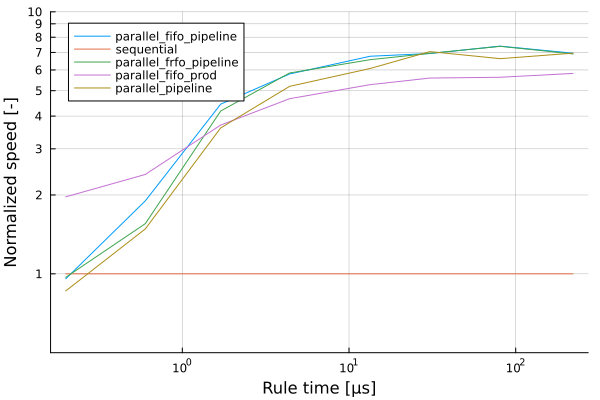

In [20]:
p = plot(
    xaxis=:log,
    yaxis=:log,
    legend=:topleft,
    xlabel="Rule time [μs]",
    ylabel="Normalized speed [-]",
    yticks=([1:10;], [string(a) for a in 1:10]),
    #xticks=(sizes, [ string(a) for a in sizes ]),
    ylim = (0.5, 10),
    gridalpha=0.3,
)

for (key, values) in pairs(points)
    if key != :rule
        plot!(p, points[:rule], points[:sequential] ./ values, label = string(key))
    end
end

p